<a href="https://colab.research.google.com/github/Badisj/Recurrent-Neural-Nets-NLP/blob/main/LAB1_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton


## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [97]:
import numpy as np
from tensorflow.keras.datasets import imdb

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

colab = False
student = True

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zero-pad each sequence a length ```max_review_length```

In [98]:
top_words = 5000 
max_review_length = 100
INDEX_FROM = 3
embedding_vector_length = 32

## Import IMDB data

In [99]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

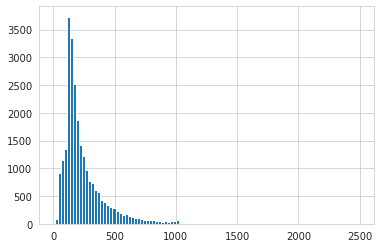

In [100]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [101]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [102]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [103]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [104]:
# --- truncate and pad input sequences

if student:
    # --- START CODE HERE (01)
    X_train = sequence.pad_sequences(X_train, maxlen = max_review_length, padding = 'post', truncating = 'post')
    X_test = sequence.pad_sequences(X_test, maxlen = max_review_length, padding = 'post', truncating = 'post')
    # --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
#print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100


# First model

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [105]:
K.clear_session()

In [106]:
# --- create the model
# CODE-RNN1-2
#Embedding(vocab_size, embedding_vector_length)
if student:
    # --- Using the Sequential API
    model1 = Sequential()
    model1.add(Embedding(input_dim = top_words, output_dim = embedding_vector_length))
    model1.add(Lambda(lambda x: K.mean(x, axis = 1)))
    model1.add(Dense(units = 1, activation = 'sigmoid'))
    # --- Using the Functional API
    inputs = Input(shape = (max_review_length,))
    y = Embedding(input_dim = top_words, output_dim = embedding_vector_length)(inputs)
    y = Lambda(lambda x: K.mean(x, axis = 1))(y)
    y = Dense(units = 1, activation = 'sigmoid')(y)
    model2 = Model(inputs = inputs, outputs = y)
    
print(model1.summary())
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
lambda (Lambda)              (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 32)           160000    
______________________________

In [107]:
# --- compile and fit the functional model
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
model1.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_split = 0.2)
print('Sequential Model trained \n')
# --- compile and fit the functional model
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
model2.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_split = 0.2)
print('Functional API model trained')

Epoch 1/5
313/313 [==============================] - 2s 6ms/step - loss: 0.6619 - accuracy: 0.6816 - val_loss: 0.6105 - val_accuracy: 0.7298
Epoch 2/5
313/313 [==============================] - 2s 6ms/step - loss: 0.5525 - accuracy: 0.7715 - val_loss: 0.5093 - val_accuracy: 0.7826
Epoch 3/5
313/313 [==============================] - 2s 6ms/step - loss: 0.4631 - accuracy: 0.8116 - val_loss: 0.4515 - val_accuracy: 0.8020
Epoch 4/5
313/313 [==============================] - 2s 6ms/step - loss: 0.4094 - accuracy: 0.8293 - val_loss: 0.4205 - val_accuracy: 0.8170
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.3756 - accuracy: 0.8424 - val_loss: 0.4039 - val_accuracy: 0.8248
Sequential Model trained 

Epoch 1/5
313/313 [==============================] - 2s 6ms/step - loss: 0.6609 - accuracy: 0.6816 - val_loss: 0.6091 - val_accuracy: 0.7412
Epoch 2/5
313/313 [==============================] - 2s 6ms/step - loss: 0.5507 - accuracy: 0.7718 - val_loss: 0.5073 - val_acc

## Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

In [108]:
# --- Final evaluation of the sequential model
scores = model1.evaluate(X_test, y_test, verbose = 0)
print("Accuracy for sequential model: %.2f%%" % (scores[1]*100))

# --- Final evaluation of the functional API model
scores = model2.evaluate(X_test, y_test, verbose = 0)
print("Accuracy for functional API model: %.2f%%" % (scores[1]*100))

Accuracy for sequential model: 81.19%
Accuracy for functional API model: 81.34%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [109]:
top_similar = 10
E1 = model1.get_weights()[0]
E2 = model2.get_weights()[0]
idx = word_to_id['great']
emb1 = E1[idx,:]
emb2 = E2[idx,:]
closest1, closest2 = [], []
dist =  [K.sum( (emb1 - E1[id, ])**2 ) for id in range(top_words)]
idxs = list(np.argsort(dist)[:top_similar])
[id_to_word[id] for id in idxs]

['great',
 'best',
 'loved',
 'amazing',
 'wonderful',
 'perfect',
 'superb',
 'excellent',
 'favorite',
 'fantastic']

# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=128$

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [110]:
K.clear_session()

In [137]:
# --- create the model

if student:
    # --- Using the Sequential API
    model1 = Sequential()
    model1.add(Embedding(input_dim = top_words, output_dim = embedding_vector_length))
    model1.add(LSTM(units = 128, activation = 'tanh', recurrent_activation = 'sigmoid', use_bias = True))
    model1.add(Dense(units = 1, activation = 'sigmoid'))
    
    # --- Using the Functional API
    inputs = Input(shape = (max_review_length,))
    y = Embedding(input_dim = top_words, output_dim = embedding_vector_length)(inputs)
    y = LSTM(units = 128, activation = 'tanh', recurrent_activation = 'sigmoid', use_bias = True)(y)
    y = Dense(units = 1, activation = 'sigmoid')(y)
    model2 = Model(inputs = inputs, outputs = y)
   
print(model1.summary())
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 32)           160000    
__________________________

In [138]:
# --- compile and fit the sequential API model
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
model1.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_data = (X_test, y_test))
print("Training Sequential Model Completed")
# --- compile and fit the functional API model
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
model2.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_data = (X_test, y_test))
print("Training Functional Model Completed")

Epoch 1/5
391/391 [==============================] - 101s 254ms/step - loss: 0.5285 - accuracy: 0.7212 - val_loss: 0.4544 - val_accuracy: 0.7941
Epoch 2/5
391/391 [==============================] - 99s 254ms/step - loss: 0.3664 - accuracy: 0.8463 - val_loss: 0.4476 - val_accuracy: 0.8140
Epoch 3/5
391/391 [==============================] - 98s 252ms/step - loss: 0.3234 - accuracy: 0.8686 - val_loss: 0.4361 - val_accuracy: 0.8099
Epoch 4/5
391/391 [==============================] - 99s 253ms/step - loss: 0.2934 - accuracy: 0.8834 - val_loss: 0.4269 - val_accuracy: 0.8067
Epoch 5/5
391/391 [==============================] - 99s 253ms/step - loss: 0.2585 - accuracy: 0.8963 - val_loss: 0.4866 - val_accuracy: 0.8019
Training Sequential Model Completed
Epoch 1/5
391/391 [==============================] - 162s 257ms/step - loss: 0.5378 - accuracy: 0.7086 - val_loss: 0.4280 - val_accuracy: 0.8116
Epoch 2/5
391/391 [==============================] - 99s 254ms/step - loss: 0.3682 - accuracy: 0.8

## Results

After only 3 epochs, you should obtain an accuracy around 88% for the test data.

In [114]:
# --- Final evaluation of the model
scores = model1.evaluate(X_test, y_test, verbose = 0)
print("Accuracy of the Sequential API model: %.2f%%" % (scores[1]*100)) 

scores = model2.evaluate(X_test, y_test, verbose = 0)
print("Accuracy of the Functional API model: %.2f%%" % (scores[1]*100)) 

Accuracy of the Sequential API model: 78.94%
Accuracy of the Functional API model: 79.60%
